In [1]:
# End-End training and testing of the new pytorch-based VGG16-deeplabv3 architecture

In [2]:
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import importlib

import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils

In [4]:
import time
import numpy as np

import data_utils
import losses

from IPython import display

In [5]:
import umap

In [8]:
img_shape = (512,1024,3)

num_classes = 14

batch_size=4

do_training = True

epochs=100000
epoch_step=250

num_projections=100

synthia_data_dir = './processed-data/1024x512/13_classes/SYNTHIA/train/'
cityscapes_data_dir = './processed-data/1024x512/13_classes/CITYSCAPES/train/'
cityscapes_val_dir = './processed-data/1024x512/13_classes/CITYSCAPES/val/'

In [7]:
importlib.reload(losses)

deeplabv3 = dlv3.vgg16_deeplabv3(activation=None)

X = deeplabv3.input
Y = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,), dtype='float32', name='label_input')

C_in = tf.keras.layers.Input(shape=deeplabv3.layers[-1].output_shape[1:], dtype='float32', name='classifier_input')
classifier = tf.keras.Model(C_in, networks.classifier_layers(C_in, num_classes = num_classes, activation='softmax'))

# A combined model, giving the output of classifier(deeplabv3(X))
combined = tf.keras.Model(X, classifier(deeplabv3(X)))
combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# A model outputting hxwx1 labels for each image. Also useful to verify the
# mIoU with Keras' built-in function. Will however also consider the 'ignore' class. 
combined_ = tf.keras.Model(X, tf.cast(tf.keras.backend.argmax(combined(X), axis=-1), 'float32'))
combined_.compile(metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# Set up training
opt = tf.keras.optimizers.Adam(lr=7e-4, epsilon=1e-8, decay=1e-6)

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y, classifier(deeplabv3(X)), from_logits=False)

# https://stackoverflow.com/questions/55434653/batch-normalization-doesnt-have-gradient-in-tensorflow-2-0
params = deeplabv3.trainable_weights + classifier.trainable_weights

updates = opt.get_updates(wce_loss, params)

train = tf.keras.backend.function(inputs=[X,Y], outputs=[wce_loss], updates=updates)

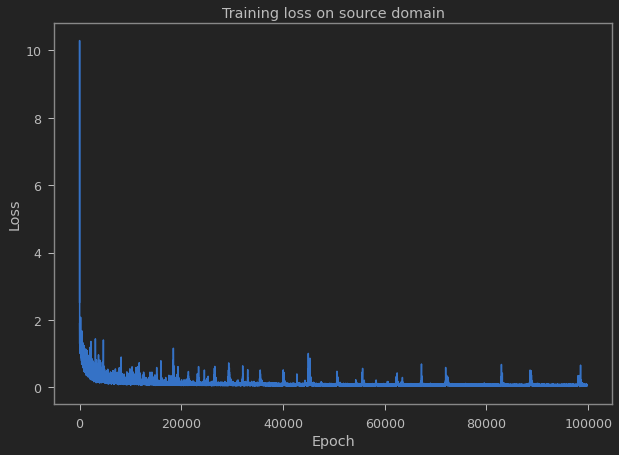

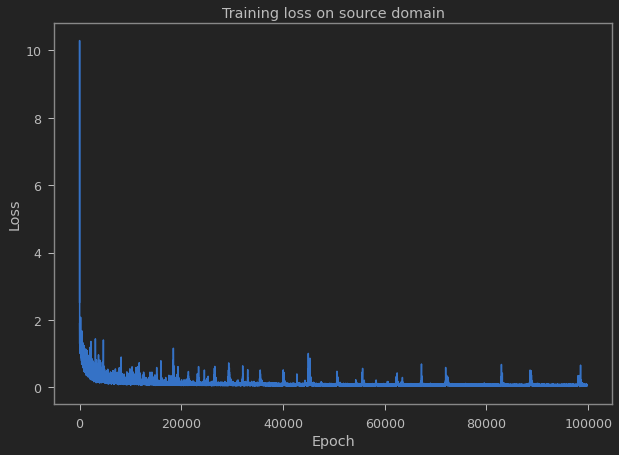

In [9]:
importlib.reload(data_utils)

# Training on synthia
if do_training == True:
    try:
        deeplabv3.load_weights("weights/SYNTHIA/vgg16_deeplabv3.h5")
        classifier.load_weights("weights/SYNTHIA/vgg16_deeplabv3_classifier.h5")

        print("Successfully loaded model. Continuing training.")
    except:
        print("Could not load previous model weights. Is a new model present?")
        
    start_time = time.time()

    fig,ax = plt.subplots(1,figsize=(10,7))

    loss_history = []

    for itr in range(epochs):
        source_train_data, source_train_labels = utils.sample_batch(synthia_data_dir, batch_size=batch_size, seed=itr)
        source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

        loss_history.append(train(inputs=[source_train_data, source_train_labels ]))

        if np.isnan(np.sum(loss_history[-1])):
            print('ERROR. ENCOUNTERED NAN')
            break

        if itr%epoch_step == 0:
            if itr != 0:
                ax.clear()
                ax.plot(np.asarray(loss_history))

            ax.set_title("Training loss on source domain")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-3)
            
        if itr % (epochs // 10) == 0 or itr == epochs - 1:
            deeplabv3.save_weights("weights/SYNTHIA/vgg16_deeplabv3.h5")
            classifier.save_weights("weights/SYNTHIA/vgg16_deeplabv3_classifier.h5")

    training_time = time.time() - start_time
else:
    deeplabv3.load_weights("weights/SYNTHIA/vgg16_deeplabv3.h5")
    classifier.load_weights("weights/SYNTHIA/vgg16_deeplabv3_classifier.h5")
    print("Loaded model weights")

In [10]:
import utils
importlib.reload(utils)

start_time = time.time()

syn_cat_iou,syn_miou = utils.compute_miou(synthia_data_dir, combined_, data_utils.label_ids_13, 0)

for k in syn_cat_iou:
    print(k, syn_cat_iou[k])
print(syn_miou)

print('Computed SYNTHIA mIoU in', time.time() - start_time)

# road 0.8697261518665685
# sidewalk 0.9113634624958296
# building 0.9569149848568662
# traffic light 0.6692568369440461
# traffic sign 0.5860773804319556
# vegetation 0.884809850749246
# sky 0.9722822745651284
# person 0.7455385370176668
# rider 0.6870540003400796
# car 0.9178665102835107
# bus 0.9289809566652807
# motorcycle 0.735781922765805
# bicycle 0.40476841625240045
# 0.7900324065564911
# Computed SYNTHIA mIoU in 764.8882532119751

road 0.8697261518665685
sidewalk 0.9113634624958296
building 0.9569149848568662
traffic light 0.6692568369440461
traffic sign 0.5860773804319556
vegetation 0.884809850749246
sky 0.9722822745651284
person 0.7455385370176668
rider 0.6870540003400796
car 0.9178665102835107
bus 0.9289809566652807
motorcycle 0.735781922765805
bicycle 0.40476841625240045
0.7900324065564911
Computed SYNTHIA mIoU in 764.8882532119751


In [11]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.16062219323000543
# sidewalk 0.10328246094751099
# building 0.5223364763754613
# traffic light 0.011561064094364857
# traffic sign 0.06003539323890042
# vegetation 0.7233449747279761
# sky 0.7246642427037422
# person 0.29851484940838546
# rider 0.013017958590237204
# car 0.18816119927371647
# bus 0.003501853119870368
# motorcycle 0.0026425066062665155
# bicycle 0.011154227304613124
# 0.21714149227854235
# Computed CITYSCAPES mIoU in 246.31135725975037

road 0.16062219323000543
sidewalk 0.10328246094751099
building 0.5223364763754613
traffic light 0.011561064094364857
traffic sign 0.06003539323890042
vegetation 0.7233449747279761
sky 0.7246642427037422
person 0.29851484940838546
rider 0.013017958590237204
car 0.18816119927371647
bus 0.003501853119870368
motorcycle 0.0026425066062665155
bicycle 0.011154227304613124
0.21714149227854235
Computed CITYSCAPES mIoU in 246.31135725975037


In [12]:
start_time = time.time()
means, _, ct = utils.learn_gaussians(synthia_data_dir, deeplabv3, combined, batch_size, data_utils.label_ids_13)
print("computed means in", time.time() - start_time)

start_time = time.time()
means, covs, ct = utils.learn_gaussians(synthia_data_dir, deeplabv3, combined, batch_size, data_utils.label_ids_13, \
                                  initial_means=means)
print("finished training gaussians in", time.time() - start_time)

np.save('./extras/means_1024x512_vgg16deeplabv3_SYNTHIA.npy', means)
np.save('./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA.npy', covs)

computed means in 2133.979922771454
finished training gaussians in 2608.9226112365723


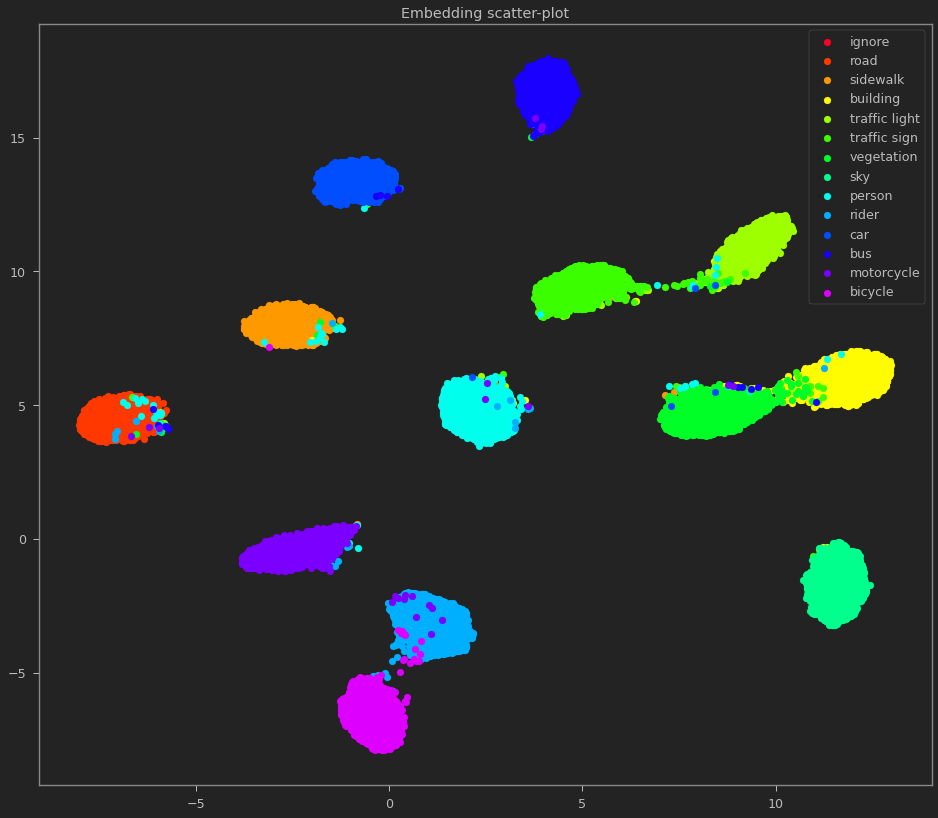

26.5272479057312


In [13]:
# Generate data from the gmm model and plot it

start_time = time.time()

n_samples = np.ones(num_classes, dtype=int)
n_samples[0] = 0
n_samples *= 2000

xx, yy = utils.sample_from_gaussians(means, covs, n_samples=n_samples)

NUM_COLORS = num_classes

reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(xx)

plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(data_utils.label_ids_13.keys())
idx = 0
for label in data_utils.label_ids_13:
    ind = yy == data_utils.label_ids_13[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()

print(time.time() - start_time)

In [19]:
importlib.reload(wasserstein_utils)

Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,) )
Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') #labels of input images oneHot
lambda2 = 5e-1

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y_s, classifier(Z_s), from_logits=False)

# Wasserstein matcing loss
theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), Z_s, theta, nclass=num_classes, Cp=None, Cq=None,)

# Overall loss is a weighted combination of the two losses
total_loss = wce_loss + lambda2*matching_loss

params = deeplabv3.trainable_weights + classifier.trainable_weights

# Optimizer and training setup
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)

updates = opt.get_updates(total_loss, params)
train = tf.keras.backend.function(inputs=[X,Z_s,Y_s,theta], outputs=[total_loss, wce_loss, matching_loss], updates=updates)

/home/serban/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
loss = []
target_miou = []

deeplabv3.load_weights("weights/SYNTHIA/vgg16_deeplabv3.h5")
classifier.load_weights("weights/SYNTHIA/vgg16_deeplabv3_classifier.h5")

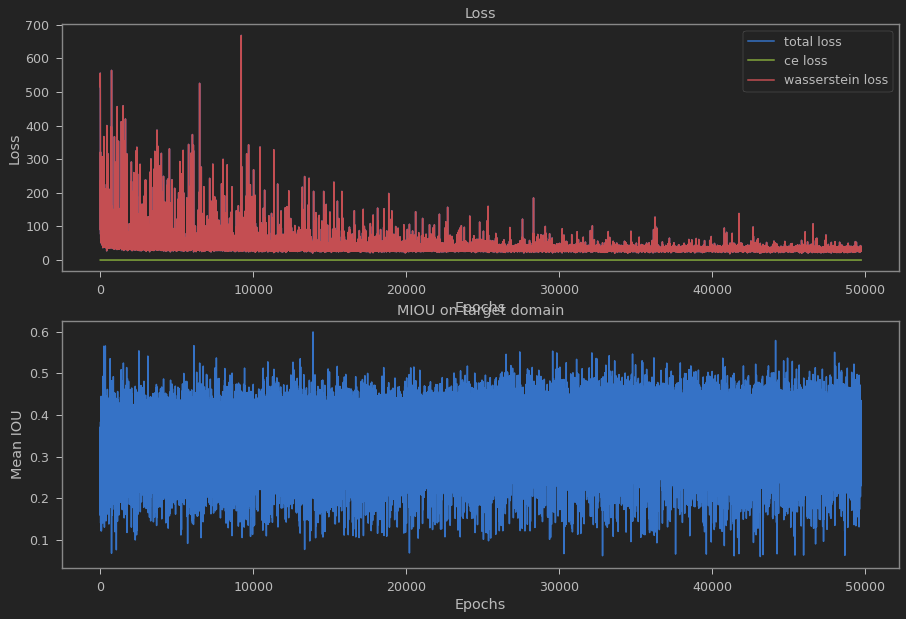

In [25]:
fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 1

thres = .99
epochs2 = 50000
epochstep = 250

for itr in range(epochs2):
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)


    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])

    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)

    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, theta_instance]))
    target_miou.append(combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 14/13)
    
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3) 

In [26]:
import utils
importlib.reload(utils)

start_time = time.time()

syn_cat_iou,syn_miou = utils.compute_miou(synthia_data_dir, combined_, data_utils.label_ids_13, 0)

for k in syn_cat_iou:
    print(k, syn_cat_iou[k])
print(syn_miou)

print('Computed SYNTHIA mIoU in', time.time() - start_time)

# road 0.6861354308215343
# sidewalk 0.6405202781359962
# building 0.8360238686557648
# traffic light 0.1289776030002515
# traffic sign 0.10267042110552024
# vegetation 0.6528797947812834
# sky 0.9118196122510973
# person 0.5862095334460907
# rider 0.3855183769716111
# car 0.6497942828365261
# bus 0.5970644987418308
# motorcycle 0.405919191873557
# bicycle 0.1580522446100113
# 0.518583472094698
# Computed SYNTHIA mIoU in 771.5304613113403

road 0.6861354308215343
sidewalk 0.6405202781359962
building 0.8360238686557648
traffic light 0.1289776030002515
traffic sign 0.10267042110552024
vegetation 0.6528797947812834
sky 0.9118196122510973
person 0.5862095334460907
rider 0.3855183769716111
car 0.6497942828365261
bus 0.5970644987418308
motorcycle 0.405919191873557
bicycle 0.1580522446100113
0.518583472094698
Computed SYNTHIA mIoU in 771.5304613113403


In [27]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7763153065516731
# sidewalk 0.5564637789728466
# building 0.7346311041154598
# traffic light 0.16149781520408138
# traffic sign 0.24949658022963137
# vegetation 0.7198758510354555
# sky 0.8226681760780595
# person 0.5149787622409793
# rider 0.22180348711792877
# car 0.7006378307519797
# bus 0.2724246094842813
# motorcycle 0.21974769344401965
# bicycle 0.34393590065336177
# 0.48419053045228905
# Computed CITYSCAPES mIoU in 238.24170112609863

road 0.7763153065516731
sidewalk 0.5564637789728466
building 0.7346311041154598
traffic light 0.16149781520408138
traffic sign 0.24949658022963137
vegetation 0.7198758510354555
sky 0.8226681760780595
person 0.5149787622409793
rider 0.22180348711792877
car 0.7006378307519797
bus 0.2724246094842813
motorcycle 0.21974769344401965
bicycle 0.34393590065336177
0.48419053045228905
Computed CITYSCAPES mIoU in 238.24170112609863


In [28]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_val_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.749731841698016
# sidewalk 0.4825237913408433
# building 0.7031377585091101
# traffic light 0.13315064643057897
# traffic sign 0.24302754658655049
# vegetation 0.7233121105747945
# sky 0.7726786821158399
# person 0.4752011635641528
# rider 0.18143739891344918
# car 0.6510831839709766
# bus 0.14654954115805577
# motorcycle 0.06881228077018865
# bicycle 0.37487197659898747
# 0.43888599401781103
# Computed CITYSCAPES mIoU in 41.31771683692932

road 0.749731841698016
sidewalk 0.4825237913408433
building 0.7031377585091101
traffic light 0.13315064643057897
traffic sign 0.24302754658655049
vegetation 0.7233121105747945
sky 0.7726786821158399
person 0.4752011635641528
rider 0.18143739891344918
car 0.6510831839709766
bus 0.14654954115805577
motorcycle 0.06881228077018865
bicycle 0.37487197659898747
0.43888599401781103
Computed CITYSCAPES mIoU in 41.31771683692932


In [29]:
deeplabv3.save_weights("weights/SYNTHIA/vgg16_deeplabv3_adapted.h5")
classifier.save_weights("weights/SYNTHIA/vgg16_deeplabv3_classifier_adapted.h5")